In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
# Standard packages
import os
import re

# Third Party
import folium
from folium import GeoJson
import branca.colormap as cm
import geojson
from geopy import distance
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import quadkey
from scipy.spatial.distance import euclidean
from sklearn.metrics import pairwise_distances
from tqdm import tqdm_notebook

# Personal
from agents.agents import Survivor, Removed, Zombie
from utils.postcodedata import read_postcode_data
from utils.simulation_utils import move_one_random_step, \
                                   find_all_zombie_positions, \
                                   find_all_survivors_positions, \
                                   inherit_zombie_attributes, \
                                   inherit_survivor_attributes, \
                                   find_pairwise_distances, \
                                   find_matches, \
                                   run_duels, \
                                   timing, \
                                   get_quadkey_as_geojson

# Set random seed
np.random.seed(42)

# Read Data

In [5]:
# Read postcode data
path = r"data/postcodes/postcodes_data.csv"
df = read_postcode_data(path)

In [6]:
# Dundee Bounding Box
dundee_bbox = {'max_lat': 56.48412 ,
               'min_lat': 56.4513,
               'max_lon': -2.921649,
               'min_lon': -3.072711}

# Filter on Dundee
dundee = df[(df['Latitude'] > dundee_bbox["min_lat"]) & 
            (df['Latitude'] < dundee_bbox["max_lat"]) &
            (df['Longitude'] > dundee_bbox["min_lon"]) &
            (df['Longitude'] < dundee_bbox["max_lon"])]

# Munz et all Simulation

In a this lighthearted example, a system of ODEs can be used to model a
"zombie invasion", using the equations specified in [Munz et al.
2009](http://mysite.science.uottawa.ca/rsmith43/Zombies.pdf).

The system is given as:

In [7]:
d = 0.0001   #Death Rate
S = 86000    #Population
A = 0.0001   #Destroy Percent
Z = 5        #Zombies
G = 0.0001   #Resurrect Percent
R = 0        #Removed
B = 0.0001   #Trasmission Percent

Survs = []
Zombs = []

for i in np.linspace(0, 5., 1000):
    
    # Calculate New Population
    dS = (B*S*Z) - (d*S)
    S = S - abs(dS)
    Survs.append(S)
    
    # Add natural deaths to removed 
    R += (d*S)
    
    # Remove resurrected
    R -= (G*R)
    
    # Calculate Zombies
    Z += B*S*Z + G*R - A*S*Z
    Zombs.append(Z)
    
    # Add Remove Zombies to removed
    R += A*S*Z

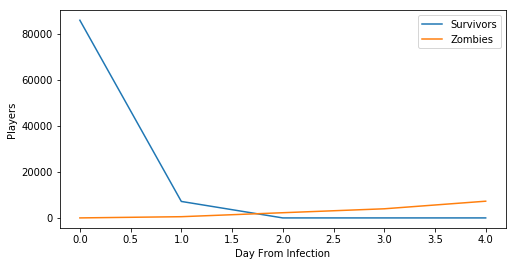

In [8]:
plt.figure(figsize = (8,4))


plt.plot(np.array(Survs)[[0,200,400,600,999]], label = 'Survivors')
plt.plot(np.array(Zombs)[[0,200,400,600,999]], label = 'Zombies')
plt.xlabel('Day From Infection')
plt.ylabel('Players')
plt.legend()

# Geo Simulation

Proposes an alternative way of simulation a zombie outbreak by moving a set of players in space.

# Initialize Population

In this section we initialize the population. We start from postcodes and their latitude and longitude location. For each postcode we know how many people are registered there based on 2011 UK Census, but we don't have any other information. Therefore we initialize each person at each postcode as a survivor, with random age and sex attributes. Based on those attributes we assign a speed.

Age distribution comes from ONS : https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/articles/overviewoftheukpopulation/july2017

Speed by age was taken from an article at the following link:
https://www.healthline.com/health/exercise-fitness/average-walking-speed#average-speed-by-age

How to adjust speed based on Age was derived from the article at the link below:
https://www.livescience.com/59289-why-men-run-faster-than-women.html



In [9]:
# Population inizialization parameter
avg_age = 40
std_age = 16
speed_by_age = pd.read_csv("data/SpeedAge.csv") # in meters per second
speeds_vector = speed_by_age['MetersSecond'].tolist()
male_women_speed_delta = 0.086
n_infected_at_start = 5
zombie_speed_ratio = 0.5

In [10]:
# Create population dictionary, at time 0 everybody is a survivor

top = dundee['Persons'].sum()
print("Total Population in Dundee: {}".format(top))

population = []

available_index = 0 #This is an ID assigned to each person

# Initialize Population assigning random attributes
for row in tqdm_notebook(dundee.itertuples()):
    
    if row.Persons == 0:
        pass 
    else:
        for person in range(row.Persons):
            
            available_index += 1
    
            survivor = Survivor()
    
            # Assign a random age
            survivor.age = np.clip(
                int(np.floor(np.random.normal(avg_age, std_age))), 0,100)
            
            # Assign a random sex (0.5 proabability of male)
            survivor.sex = np.random.choice(['M', 'F'])
        
            # Assign speed as a function of age and sex
            survivor.speed = speeds_vector[survivor.age]
            if survivor.sex == 'M':
                survivor.speed = survivor.speed * (1-male_women_speed_delta)
        
            # Assign latitude and longitude based on postcode location
            move_params = {'start_lat': row.Latitude,
                           'start_lon': row.Longitude,
                           'km': 0.01}
            dist, lat_n, lon_n = move_one_random_step(**move_params)
            survivor.latitude = lat_n
            survivor.longitude = lon_n
            #TODO add some random noise
            
            # Create Person Dictionary
            person_dict = {'id': available_index, 
                           'type': survivor}
            population.append(person_dict)


Total Population in Dundee: 84514


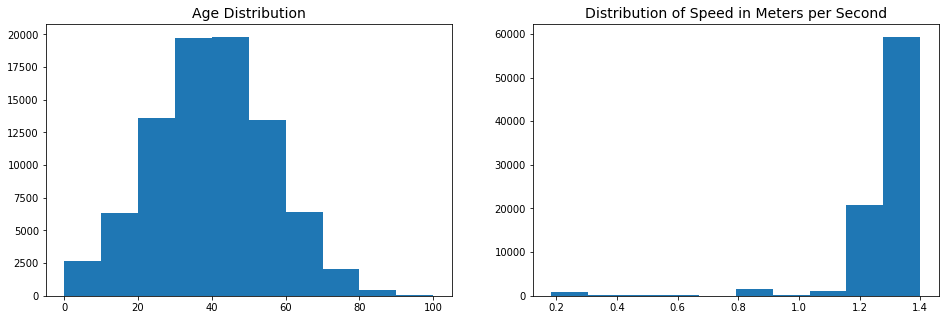

In [11]:
# Plot speed and age distributions
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.hist([x['type'].age for x in population])
plt.title('Age Distribution', size = 14)

plt.subplot(122)
plt.hist([x['type'].speed for x in population])
plt.title('Distribution of Speed in Meters per Second', size = 14)

plt.show()

In [12]:
# After initilizing the population infect random people
idx_first_infected = np.random.choice(range(len(population)), size = n_infected_at_start)

# Zombify first infected people
for idx in idx_first_infected:
    
    player = population[idx]['type']
    population[idx]['type'] = inherit_survivor_attributes(player, zombie_speed_ratio)

# Simulation

We simulate how the zombie outbreak would spread over days, by running a step for each hour.

1. We move each person a random step in latitude-longitude. Each person will move for a random fraction of the hour and won't move faster than their assigned walking speed. **NOTE**: for this first version of the simulation we will only have people moving on foot. Also, each hour people will decide whether to move or not based on a probability function. People are not allowed to move out of the bounding box, to simulate a close system, o a system where the balance of people moving in and moving out is null. 

2. After a move is made we check the pairwise distances of the zombies in the system with all the other survivors. If a zombie is close to a survivor then there will be a duel. This can end up with the zombification of the survivor, survival, or removal of the zombie.


In [14]:
# Simulation Parameters

move_prob = 0.1 # Probability a person will move or not
km = 1
survival_prob = 0.8
zombie_prob = 0.1
removal_prob = 0.1
time_steps = 3
threshold_distance = 0.013/40 #approx 25 meters
quadkey_level = 18

In [15]:
# Start Simulation

# Move each person 1 step

for time_step in range(time_steps):
    
    dists = []
    
    # Move each player if it's a zombie or a survivor
    for p in tqdm_notebook(population):
        
        if p['type'].__repr__() in ['Survivor', 'Zombie']:
            
            # Change position only if player decides to move
            if np.random.choice([1,0], p = [move_prob, 1-move_prob]) == 1:
                
                # Find how far player will move in an hour in kilometers
                move_mins = np.clip(np.random.normal(30, 10,), a_min=0, a_max=60)
                km = (move_mins * 60 * p['type'].speed) / 1000
                
                # Move one random step and get new latitude longitude
                lat_s, lon_s = p['type'].latitude, p['type'].longitude
                move_params = {'start_lat': lat_s,
                               'start_lon': lon_s,
                               'km': km,
                               'bbox': dundee_bbox,
                               'iterations': 3,
                               'verbose' : False,
                               'get_distance': False}
                dist, lat_n, lon_n = move_one_random_step(**move_params)
                
                p['type'].path.append((lat_s, lon_s))
                p['type'].latitude = lat_n
                p['type'].longitude = lon_n
                
            else:
                pass
            
    # After all the population has made a move check who is close
    # to a zombie
    zombies, survivors, matches = find_pairwise_distances(population, quadkey_level)
    
    # Now that we have far is each player from each other
    # find the pairs that have less than 25 meters distance
    
    meetings = find_matches(matches, threshold_distance)
    dead_survivors, dead_zombies = run_duels(
        meetings, survival_prob, zombie_prob, removal_prob)
    
    for zs in dead_zombies:

        idx = zs[1][0]
        zombie_idx = zombies[idx][0]
        player = population[zombie_idx-1]['type']

        new_state = inherit_zombie_attributes(player)
        population[zombie_idx-1]['type'] = new_state
        
        
    for ds in dead_survivors:
    
        idx = ds[1][1]
        surv_idx = survivors[idx][0]
        player = population[surv_idx-1]['type']

        new_state = inherit_survivor_attributes(player, zombie_speed_ratio)
        population[surv_idx-1]['type'] = new_state

    print(len(list(filter(lambda x: x['type'].__repr__() == 'Removed', population))))
    print(len(list(filter(lambda x: x['type'].__repr__() == 'Zombie', population))))


5 Zombies
360 Candidate Survivors
Elapsed time: 2.670222759246826
5
31



31 Zombies
282 Candidate Survivors
Elapsed time: 3.2566447257995605
32
105



105 Zombies
330 Candidate Survivors
Elapsed time: 3.1451902389526367
116
113


In [16]:
# Stato of the population

rem = list(filter(lambda x: x['type'].__repr__() == 'Removed', population))
print(f"After {time_steps} extra time steps {len(rem)} players removed")
zom = list(filter(lambda x: x['type'].__repr__() == 'Zombie', population))
print(f"After {time_steps} extra time steps {len(zom)} zombies")
surv = list(filter(lambda x: x['type'].__repr__() == 'Survivor', population))
print(f"After {time_steps} extra time steps {len(surv)} survivors are left")

After 3 extra time steps 116 players removed
After 3 extra time steps 113 zombies
After 3 extra time steps 84285 survivors are left


# Map

In [17]:
# Find all quadkeys

all_pops = [(x['type'].latitude, x['type'].longitude) for x in population]
qks_str = [str(quadkey.from_geo(pop, 17)) for pop in all_pops]

In [18]:
# Create a quadkey dataframe
qks_df = pd.DataFrame(pd.Series(qks_str).value_counts()).reset_index()
qks_df.columns = ['Quadkey', 'Frequency']


In [24]:
### Plot where zombies are spread

# Find zombie dataframe
zom_qk = [str(quadkey.from_geo(x[1], 17)) for x in zombies]
zom_qk = pd.DataFrame(pd.Series(zom_qk).value_counts()).reset_index()
zom_qk.columns = ['Quadkey', 'Frequency']

# Join the two dataframes
zom_freqs = pd.merge(qks_df.drop('Frequency', 1), zom_qk, on = 'Quadkey', how = 'left')
zom_freqs.fillna(0, inplace = True)

In [25]:
# Initialize Map
centroid = np.median(dundee['Latitude']), np.median(dundee['Longitude'])
m = folium.Map(centroid, zoom_start=13)

# Create Color Map
linear = cm.LinearColormap(['green', 'yellow', 'red'],
                vmin=zom_freqs["Frequency"].min(), 
                vmax=zom_freqs["Frequency"].max())

geojs = []

for idx, q in zom_freqs.iterrows():
    qk = quadkey.QuadKey(q["Quadkey"])
    col = linear(q["Frequency"])
    
    geoj = get_quadkey_as_geojson(qk)
    geoj["properties"] = {"style": {"fillColor":q["Frequency"]}}
    geojs.append(geoj)


Gj = GeoJson(
            dict({'type': 'FeatureCollection', 'features':geojs}),
            style_function=lambda feature: {
                'fillColor': linear(feature['properties']['style']['fillColor']),
                'color': linear(feature['properties']['style']['fillColor']),
                'weight': 0.5,
                'dashArray': '5, 5'
            }
        )

Gj.add_to(m)

cm.caption = 'A colormap caption'
m.add_child(linear)


In [430]:
# import folium

# centroid = np.median(dundee['Latitude']), np.median(dundee['Longitude'])
# m = folium.Map(centroid, zoom_start=13)

# points = list(zip(dundee['Longitude'], dundee['Latitude']))

# for point in zombie_pos:
    
#     folium.CircleMarker(point, radius = 0.5, color = 'red').add_to(m)
    
# for point in rem_pos:
#     folium.CircleMarker(point, radius = 0.5, color = 'green', alpha = 0.5).add_to(m)
